In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt
from peft import PeftModel

/home/user/code/conda/envs/mteb-benchmark/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
model_name = "Llama_Lora"
prompt = True

In [20]:
if model_name == "Llama_new":
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B", cache_dir="/home/user/models")
        tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B", device_map="auto", cache_dir="/home/user/models", output_hidden_states=True, output_attentions=True)
elif model_name == "Llama_Lora":
        BASE    = "meta-llama/Llama-3.2-1B"
        CKPT    = "/home/user/data/LLM2vec/llama_lora/llama-lora-PromptClustering_last_dropout0.05_bs120_lre-5_temp0.2_qwenwiki_noEOS_6layers/checkpoint-20000" #100 is optimum vs 20000

        # 1. load tokenizer (it will pick up the vocab, merges, special_tokens, etc. from the checkpoint)
        tokenizer = AutoTokenizer.from_pretrained(CKPT, cache_dir="/home/user/models")
        tokenizer.pad_token_id = tokenizer.eos_token_id

        # 2. load the *base* model exactly as before
        model = AutoModelForCausalLM.from_pretrained(
            BASE,
            torch_dtype=torch.float16,
            device_map="auto",
            cache_dir="/home/user/models",
            output_attentions=True
        )

        # 3. attach your LoRA adapter from the checkpoint dir
        model = PeftModel.from_pretrained(model, CKPT, is_trainable=False)
        model.eval()

/home/user/code/conda/envs/mteb-benchmark/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [21]:
text = "a man is driving a car"
if prompt == True:
    text = [f'This sentence: "{text}" belongs to the following cluster:']

In [22]:
text

['This sentence: "a man is driving a car" belongs to the following cluster:']

In [23]:
inputs = tokenizer(text, return_tensors="pt")
inputs = {key: value.to(model.device) for key, value in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, return_dict=True)

In [24]:
all_attns = outputs.attentions
last_attn = all_attns[-1][0].detach().cpu()              # (heads, seq_len, seq_len)
query_idx = last_attn.size(1) - 1                         # index of your final token
attn_from_last = last_attn[:, query_idx, :]               # (heads, seq_len): how last query attends to each key
total_received = attn_from_last.mean(dim=0).numpy()[1:]   # average over heads, drop BOS

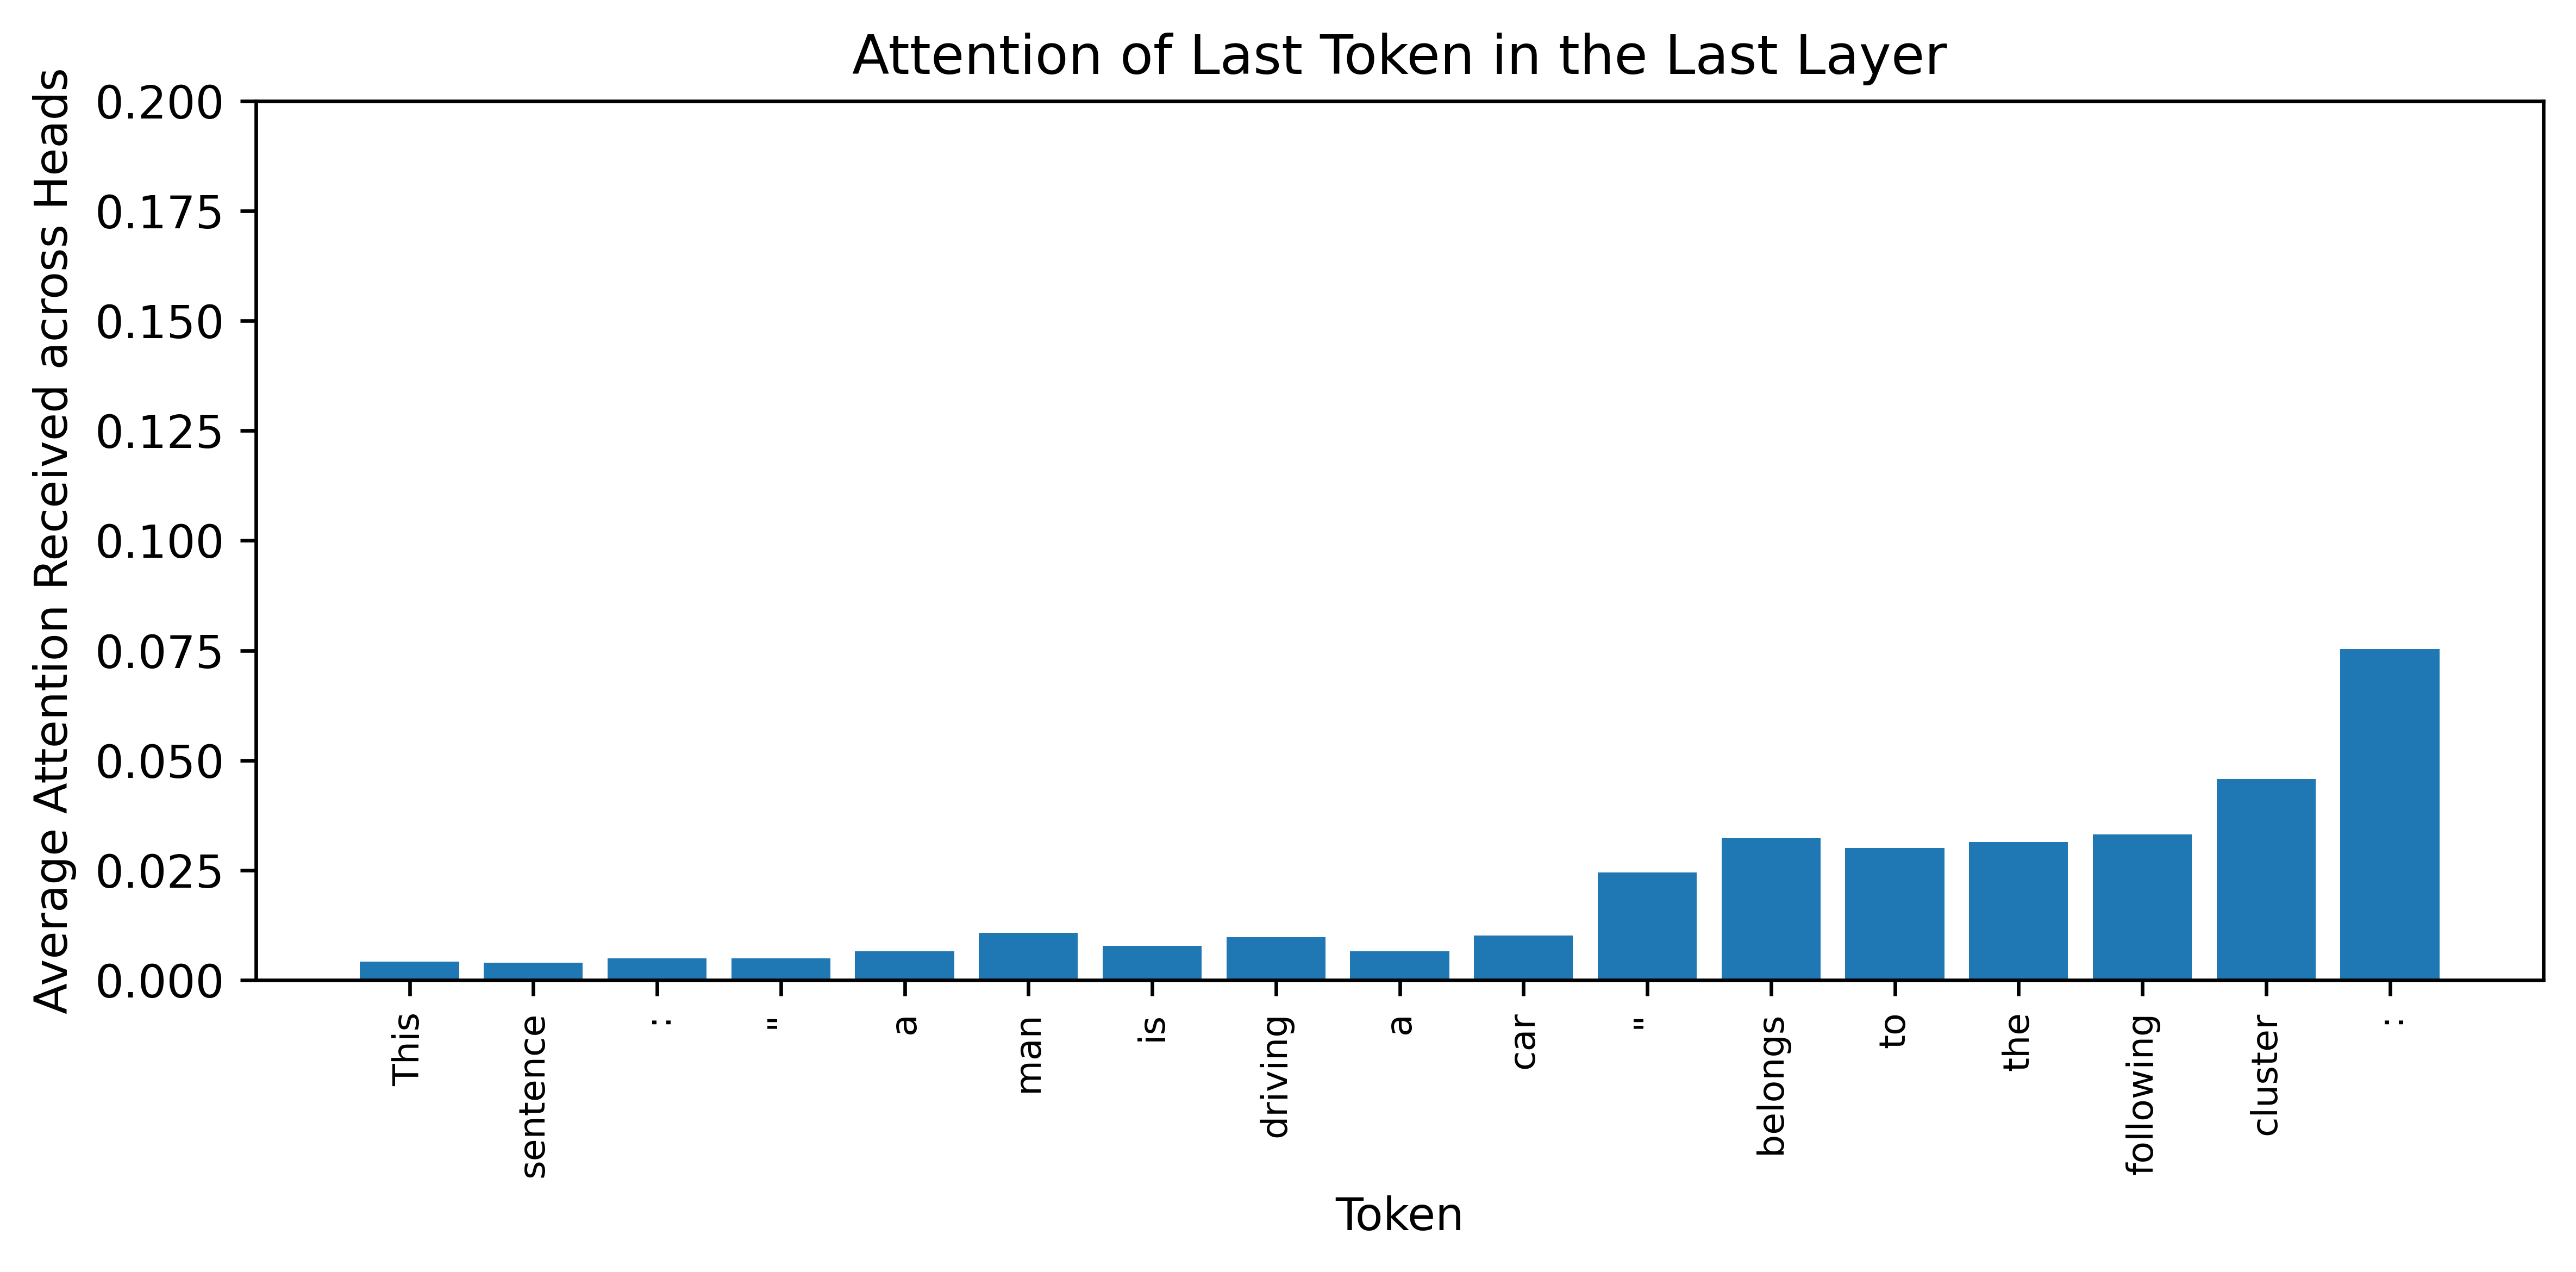

In [25]:
ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(ids[0])
tokens = [t.lstrip("Ġ") for t in tokens]
labels = tokens[1:] 

ymax = 0.2

# 4. Plot
plt.figure(figsize=(8, 4), dpi=600)
x = list(range(len(total_received)))

plt.bar(x, total_received, width=0.8)
plt.ylim(0, ymax)
plt.xticks(x, labels, rotation=90, fontsize=8)

plt.xlabel("Token")
plt.ylabel("Average Attention Received across Heads")
plt.title("Attention of Last Token in the Last Layer")

plt.tight_layout()
plt.show()

In [26]:
total_received

array([0.00414 , 0.003944, 0.00498 , 0.004963, 0.006554, 0.0108  ,
       0.007767, 0.009735, 0.00661 , 0.01009 , 0.02452 , 0.0323  ,
       0.03006 , 0.0314  , 0.03317 , 0.04575 , 0.0754  ], dtype=float16)

In [1]:
total_received1 = [0.00279534, 0.00946081, 0.01232553, 0.01366531, 0.01074875,
       0.00692804, 0.00171735, 0.00710688, 0.00317365, 0.01306856,
       0.01187358, 0.00934555, 0.0203566 , 0.02036364, 0.01558017,
       0.04964152, 0.18440574]
total_received2 = [0.000916, 0.002035, 0.003925, 0.006016, 0.00771 , 0.01245 ,
       0.005424, 0.02487 , 0.01281 , 0.0363  , 0.006283, 0.00327 ,
       0.0174  , 0.012825, 0.00861 , 0.0265  , 0.1532  ]
total_received3 = [0.00414 , 0.003944, 0.00498 , 0.004963, 0.006554, 0.0108  ,
       0.007767, 0.009735, 0.00661 , 0.01009 , 0.02452 , 0.0323  ,
       0.03006 , 0.0314  , 0.03317 , 0.04575 , 0.0754  ]

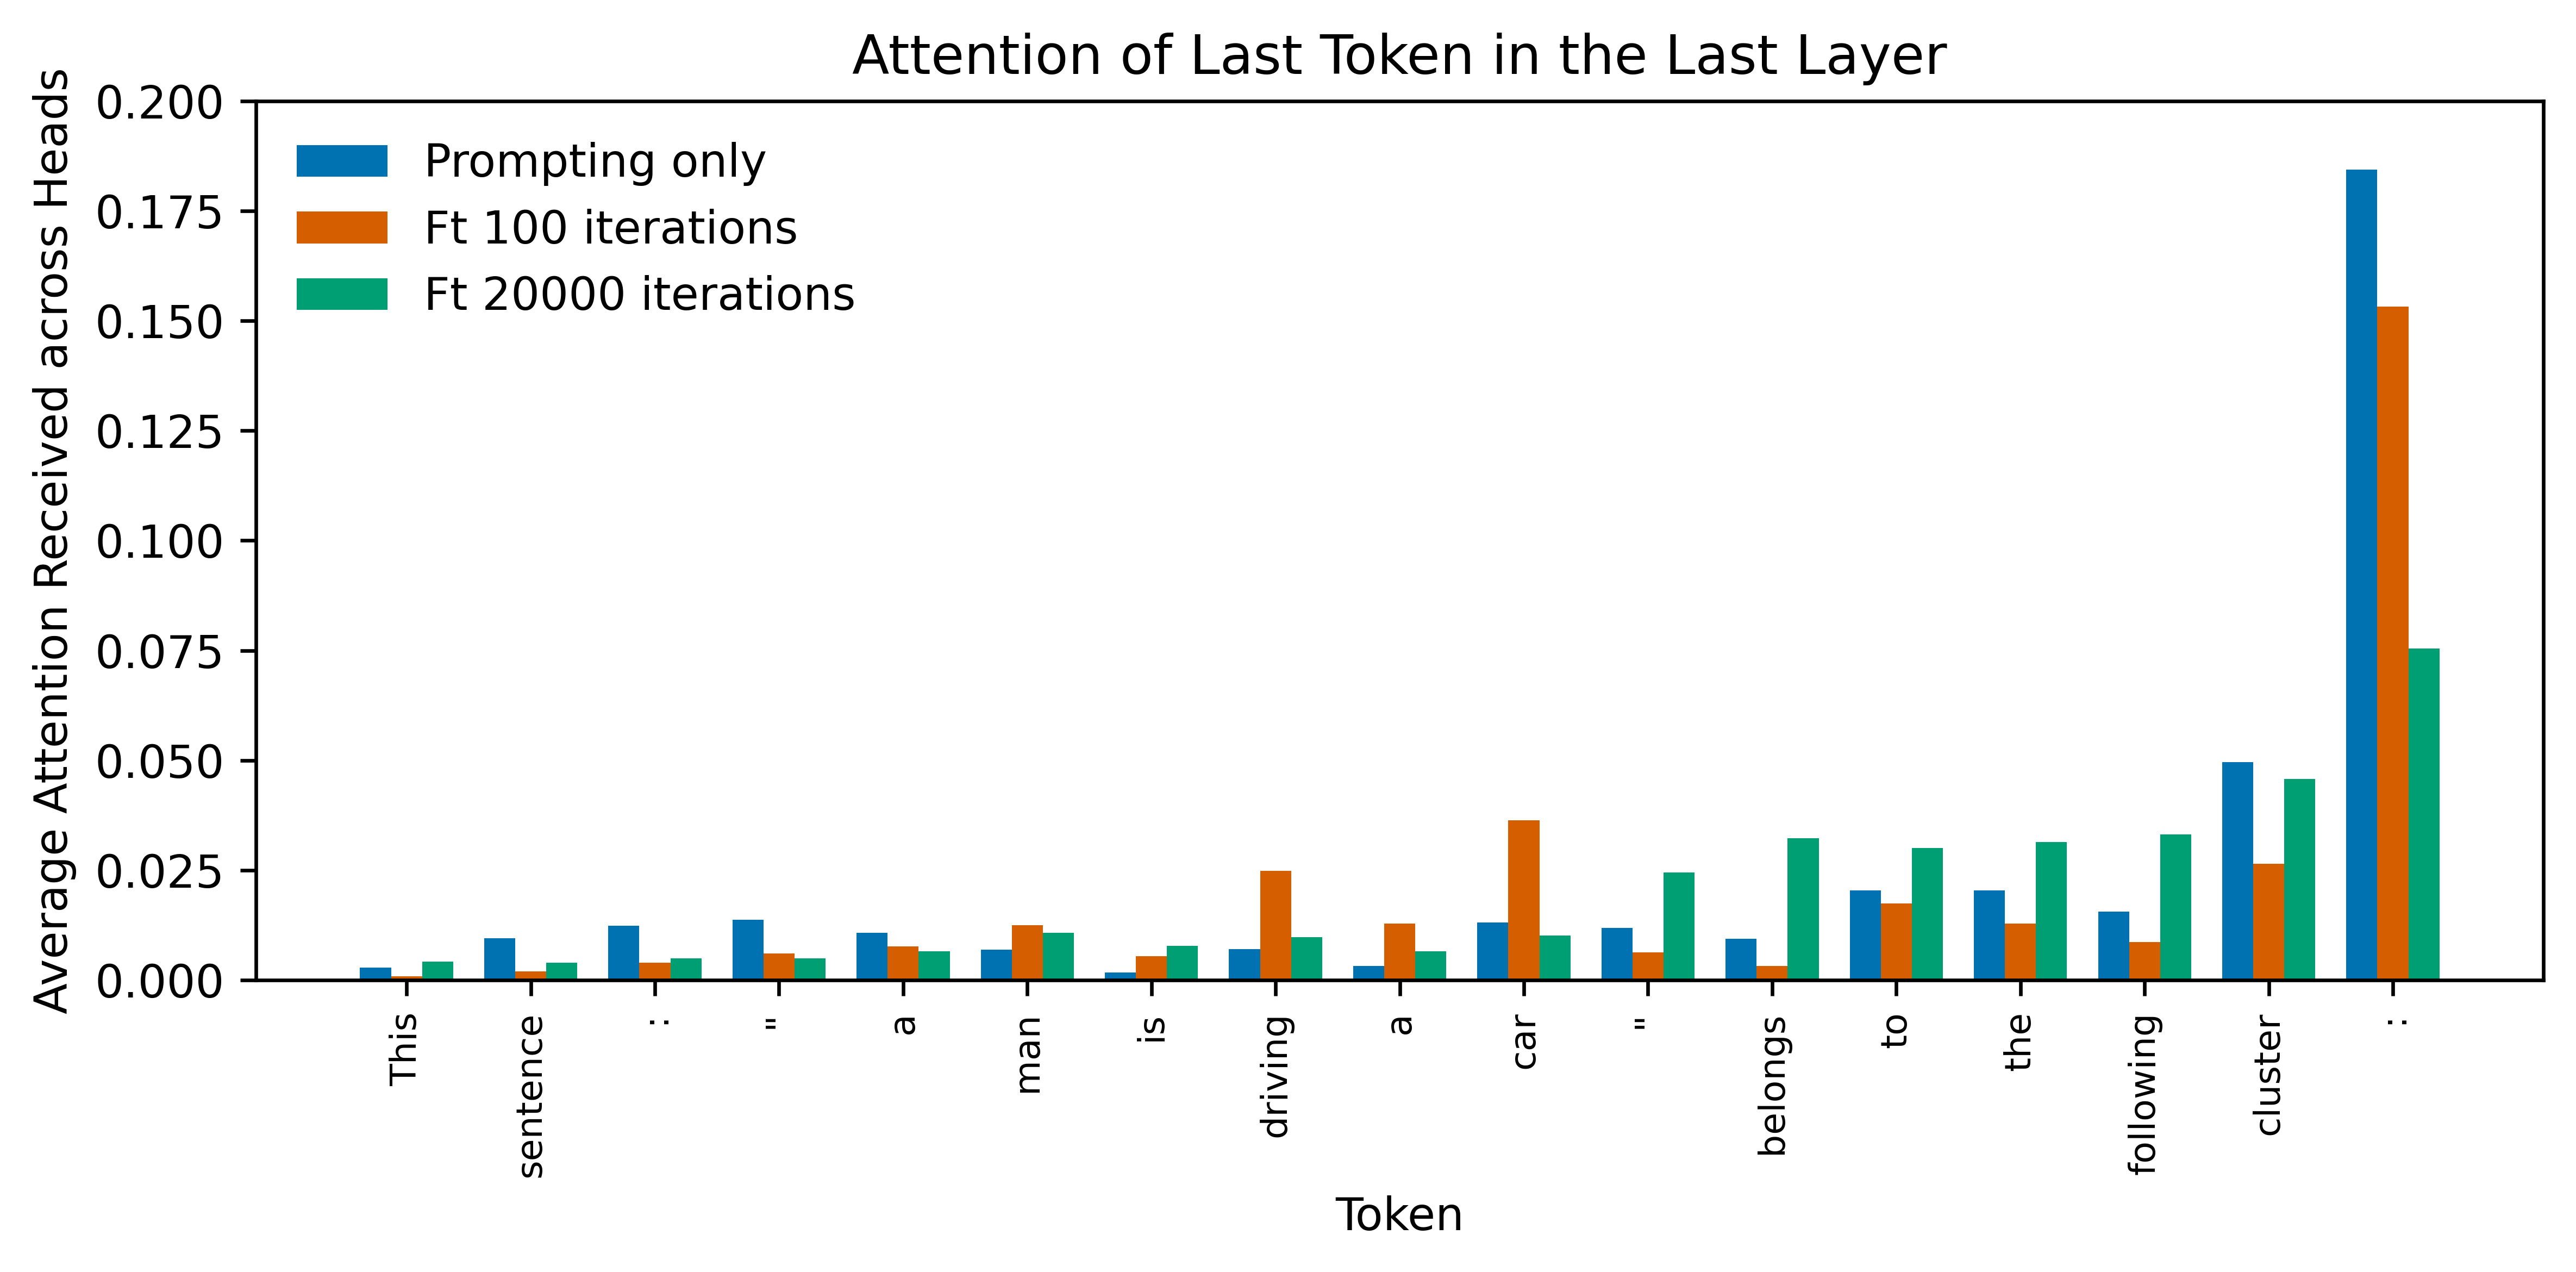

In [29]:
import numpy as np
import matplotlib.pyplot as plt

ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(ids[0])
tokens = [t.lstrip("Ġ") for t in tokens]
labels = tokens[1:]                 

total_received1 = [0.00279534, 0.00946081, 0.01232553, 0.01366531, 0.01074875,
                   0.00692804, 0.00171735, 0.00710688, 0.00317365, 0.01306856,
                   0.01187358, 0.00934555, 0.0203566 , 0.02036364, 0.01558017,
                   0.04964152, 0.18440574]
total_received2 = [0.000916, 0.002035, 0.003925, 0.006016, 0.00771 , 0.01245 ,
                   0.005424, 0.02487 , 0.01281 , 0.0363  , 0.006283, 0.00327 ,
                   0.0174  , 0.012825, 0.00861 , 0.0265  , 0.1532  ]
total_received3 = [0.00414 , 0.003944, 0.00498 , 0.004963, 0.006554, 0.0108  ,
                   0.007767, 0.009735, 0.00661 , 0.01009 , 0.02452 , 0.0323  ,
                   0.03006 , 0.0314  , 0.03317 , 0.04575 , 0.0754  ]

ymax       = 0.2
bar_width  = 0.25
x          = np.arange(len(labels))            
plt.figure(figsize=(8, 4), dpi=600)

plt.bar(x - bar_width, total_received1, width=bar_width,
        color='#0072B2', label='Prompting only')
plt.bar(x,              total_received2, width=bar_width,
        color='#D55E00', label='Ft 100 iterations')
plt.bar(x + bar_width, total_received3, width=bar_width,
        color='#009E73', label='Ft 20000 iterations')

plt.ylim(0, ymax)
plt.xticks(x, labels, rotation=90, fontsize=8)

plt.xlabel("Token")
plt.ylabel("Average Attention Received across Heads")
plt.title("Attention of Last Token in the Last Layer")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

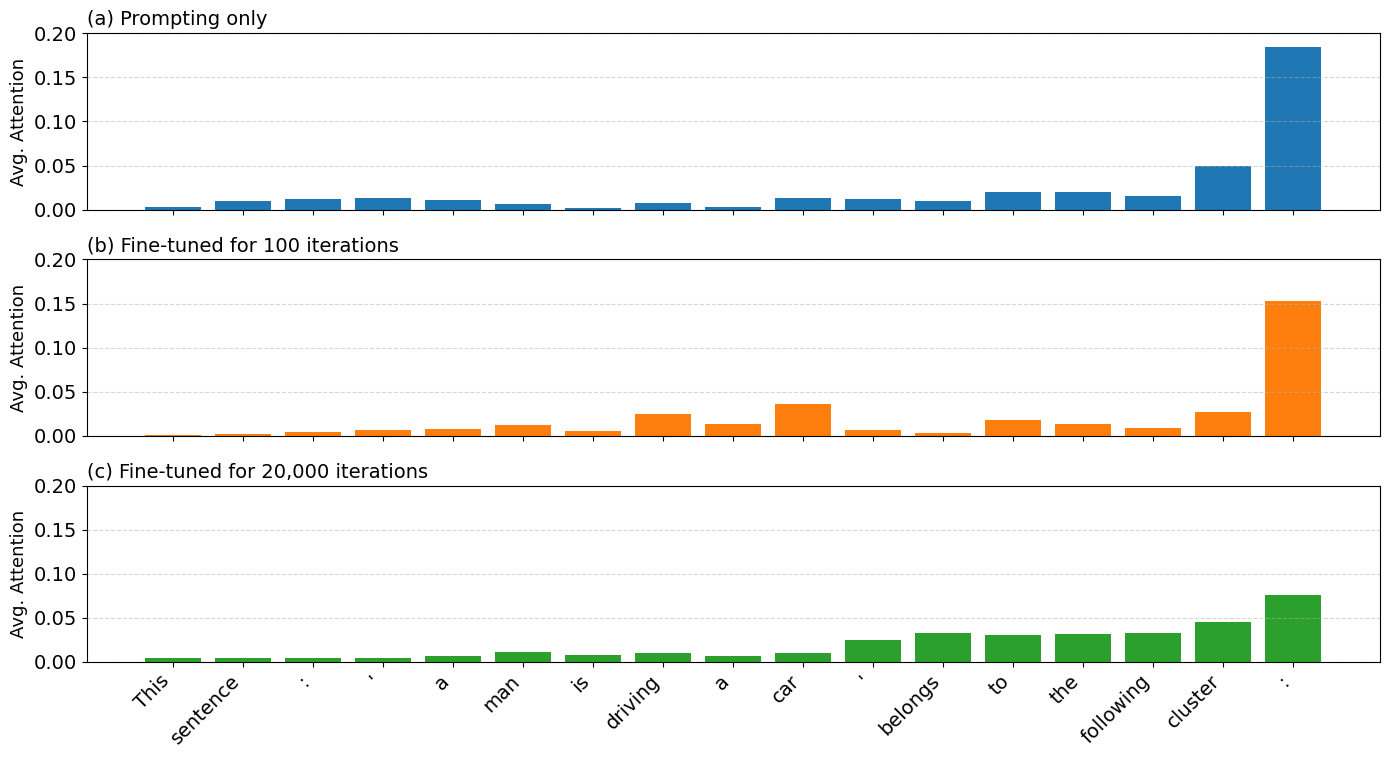

In [6]:
import matplotlib.pyplot as plt

# Attention values
total_received1 = [0.00279534, 0.00946081, 0.01232553, 0.01366531, 0.01074875,
                   0.00692804, 0.00171735, 0.00710688, 0.00317365, 0.01306856,
                   0.01187358, 0.00934555, 0.0203566 , 0.02036364, 0.01558017,
                   0.04964152, 0.18440574]
total_received2 = [0.000916, 0.002035, 0.003925, 0.006016, 0.00771 , 0.01245 ,
                   0.005424, 0.02487 , 0.01281 , 0.0363  , 0.006283, 0.00327 ,
                   0.0174  , 0.012825, 0.00861 , 0.0265  , 0.1532  ]
total_received3 = [0.00414 , 0.003944, 0.00498 , 0.004963, 0.006554, 0.0108  ,
                   0.007767, 0.009735, 0.00661 , 0.01009 , 0.02452 , 0.0323  ,
                   0.03006 , 0.0314  , 0.03317 , 0.04575 , 0.0754  ]

# Token list
tokens = ["This", "sentence", ":", "'", "a", "man", "is", "driving", "a", "car", "'",
          "belongs", "to", "the", "following", "cluster", ":"]

# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

titles = ["(a) Prompting only", "(b) Fine-tuned for 100 iterations", "(c) Fine-tuned for 20,000 iterations"]
data = [total_received1, total_received2, total_received3]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Apply font settings
label_fontsize = 13
tick_fontsize = 14
title_fontsize = 14

for i, ax in enumerate(axs):
    ax.bar(range(len(tokens)), data[i], color=colors[i])
    ax.set_ylabel("Avg. Attention", fontsize=label_fontsize)
    ax.set_ylim(0, 0.2)
    ax.set_title(titles[i], loc="left", fontsize=title_fontsize)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

# Shared title
#fig.suptitle("Attention Received by Each Token from the Final Token in the Last Layer", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save to high-res PNG
plt.savefig("/home/user/attention_plot.png", dpi=600, bbox_inches='tight')
# Optionally also save as PDF
# plt.savefig("attention_plot.pdf", dpi=600, bbox_inches='tight')

plt.show()